# Transfer Learning with Image Augmentation

## Model Creation

### Loading Model weights

In [9]:
! wget  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O ./inception-v3-weigths.h5

--2023-12-31 16:57:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.194.219, 142.250.194.251, 142.250.77.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.194.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception-v3-weigths.h5’

./inception-v3-weig 100%[===================>]  83.84M   894KB/s    in 73s     

2023-12-31 17:00:09 (1.15 MB/s) - ‘./inception-v3-weigths.h5’ saved [87910968/87910968]



### Creating Model

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers


pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights('./inception-v3-weigths.h5')

for layer in pre_trained_model.layers:
    layer.trainable = False


In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

print(last_layer.output_shape)

(None, 7, 7, 768)


In [28]:
from tensorflow.keras import Model

top_layer = layers.Flatten()(last_output)
top_layer = layers.Dense(1024,activation='relu')(top_layer)
top_layer = layers.Dropout(0.2)(top_layer)
top_layer = layers.Dense(1,activation='sigmoid')(top_layer)

model = Model(pre_trained_model.input, top_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94

In [30]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-3),
    metrics=['accuracy']
)

## Dataset Download

In [18]:
! wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-12-31 17:37:01--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.167.219, 142.250.192.219, 142.250.77.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.167.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  2.01MB/s    in 35s     

2023-12-31 17:37:36 (1.89 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [22]:
! unzip -q cats_and_dogs_filtered.zip

In [31]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'cats_and_dogs_filtered/train/'
VALIDATION_DIR = 'cats_and_dogs_filtered/validation/'

train_data_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    zoom_range=0.25,
    horizontal_flip=True,
    height_shift_range=0.25,
    width_shift_range=0.25,
    shear_range=0.25
)

train_gen = train_data_gen.flow_from_directory(
    TRAIN_DIR,
    batch_size=512,
    class_mode='binary',
    target_size=(150,150)
)

val_data_gen = ImageDataGenerator(
    rescale=1/255
)

val_gen = val_data_gen.flow_from_directory(
    VALIDATION_DIR,
    class_mode='binary',
    target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model training

In [32]:
hist_data = model.fit(train_gen,validation_data=val_gen,epochs=10)

Epoch 1/10
4/4 [==============================] - 25s 6s/step - loss: 13.0474 - accuracy: 0.5770 - val_loss: 3.9721 - val_accuracy: 0.5590
Epoch 2/10
4/4 [==============================] - 25s 6s/step - loss: 2.0468 - accuracy: 0.6995 - val_loss: 0.1568 - val_accuracy: 0.9310
Epoch 3/10
4/4 [==============================] - 26s 7s/step - loss: 0.2218 - accuracy: 0.9045 - val_loss: 0.1165 - val_accuracy: 0.9580
Epoch 4/10
4/4 [==============================] - 27s 7s/step - loss: 0.1790 - accuracy: 0.9230 - val_loss: 0.1028 - val_accuracy: 0.9560
Epoch 5/10
4/4 [==============================] - 28s 7s/step - loss: 0.1872 - accuracy: 0.9255 - val_loss: 0.1507 - val_accuracy: 0.9350
Epoch 6/10
4/4 [==============================] - 27s 7s/step - loss: 0.5262 - accuracy: 0.8075 - val_loss: 0.2812 - val_accuracy: 0.8740
Epoch 7/10
4/4 [==============================] - 28s 7s/step - loss: 0.2808 - accuracy: 0.8820 - val_loss: 0.0980 - val_accuracy: 0.9610
Epoch 8/10
4/4 [=================

## Plotting Accuracy

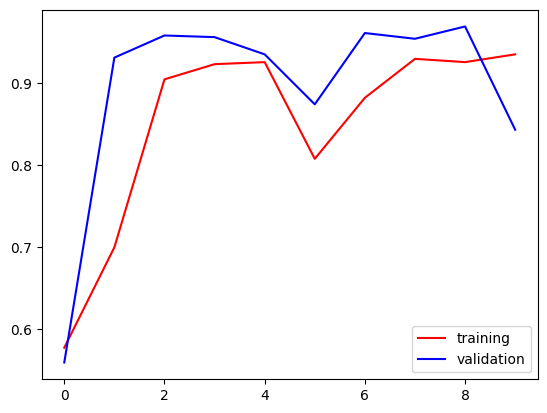

In [33]:
import matplotlib.pyplot as plt

plt.plot(hist_data.history['accuracy'],'r',label='training')
plt.plot(hist_data.history['val_accuracy'],'b',label='validation')
plt.legend()
plt.show()

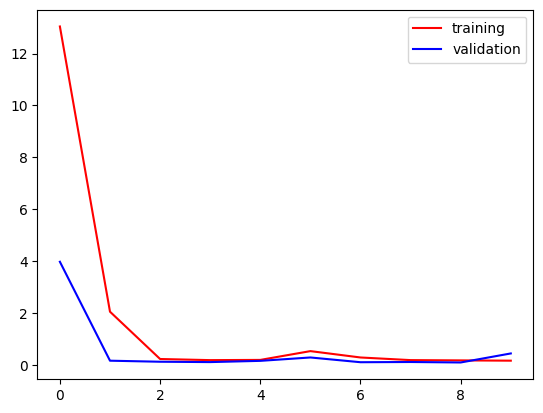

In [34]:
plt.plot(hist_data.history['loss'],'r',label='training')
plt.plot(hist_data.history['val_loss'],'b',label='validation')
plt.legend()
plt.show()